[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/asteroid-team/asteroid/blob/master/notebooks/00_GettingStarted.ipynb)

## About Asteroid

Asteroid is an open-source, community-based toolkit made to design, train, evaluate, use and share audio source separation models such as Deep clustering ([Hershey et al.](https://arxiv.org/abs/1508.04306)), ConvTasNet ([Luo et al.](https://arxiv.org/abs/1809.07454)) DPRNN ([Luo et al.](https://arxiv.org/abs/1910.06379)) etc...

## About this tutorial

In this tutorial you will learn to:

- Perform speech separation inference using a pretrained model.
- Run a very simple training on a tiny dataset.

Training models on a larger dataset/your own data and writing your own models will be explained in another tutorial.

## Install Asteroid

Install Asteroid to get started:

In [2]:
%%capture
!pip install -U asteroid

## Pretrained model speech separation

Asteroid comes with [pretrained models](https://huggingface.co/models?filter=asteroid) that help you get started quickly, like the 8 kHz [DPRNN](https://huggingface.co/mpariente/DPRNNTasNet-ks2_WHAM_sepclean).

As an example audio file to separate, you can use a mixture from the Deep clustering paper. Let's download it and listen to the unseparated version:

In [3]:
%%capture
!wget https://www.merl.com/demos/deep-clustering/media/female-female-mixture.wav

In [4]:
from IPython.display import display, Audio

display(Audio("female-female-mixture.wav"))

### Separate using the `asteroid-infer` CLI

The `asteroid-infer` command will download a model from the Hugging Face model hub and run separation on each of the files given, creating 2 estimated sources `_est1.wav` and `_est2.wav`:

In [5]:
!asteroid-infer "mpariente/DPRNNTasNet-ks2_WHAM_sepclean" --files female-female-mixture.wav
!echo "-----"
!ls

-----
female-female-mixture_est1.wav	female-female-mixture.wav
female-female-mixture_est2.wav	sample_data


In [6]:
display(Audio("female-female-mixture_est1.wav"))
display(Audio("female-female-mixture_est2.wav"))

### Separate in Python

You can also run separation using Python code.

In [9]:
from asteroid.models import BaseModel
import soundfile as sf

# 'from_pretrained' automatically uses the right model class (asteroid.models.DPRNNTasNet).
model = BaseModel.from_pretrained("mpariente/DPRNNTasNet-ks2_WHAM_sepclean")

# You can pass a NumPy array:
mixture, _ = sf.read("female-female-mixture.wav", dtype="float32", always_2d=True)
# Soundfile returns the mixture as shape (time, channels), and Asteroid expects (batch, channels, time)
mixture = mixture.transpose()
mixture = mixture.reshape(1, mixture.shape[0], mixture.shape[1])
out_wavs = model.separate(mixture)

# Or simply a file name:
model.separate("female-female-mixture.wav")

/usr/local/lib/python3.6/dist-packages/asteroid/separate.py:162: UserWarning: File female-female-mixture_est1.wav already exists, pass `force_overwrite=True` to overwrite it
  UserWarning,


### Visualize the results

You can visualize the separation results as magnitude spectrograms:

In [10]:
%%capture
!pip install librosa

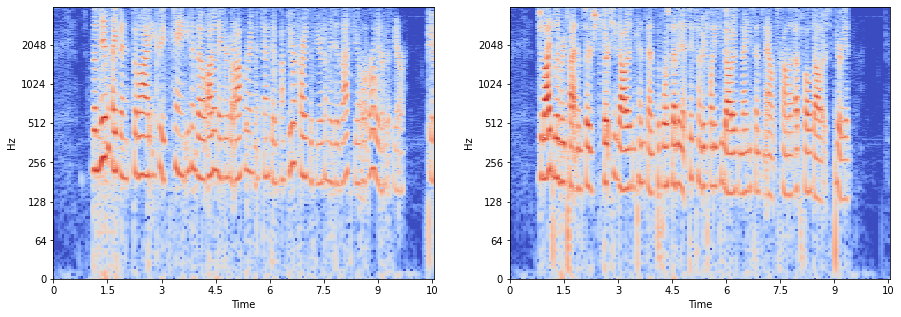

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


def show_magspec(waveform, **kw):
    return librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(librosa.stft(waveform))),
        y_axis="log", x_axis="time",
        **kw
    )


est1 = sf.read("female-female-mixture_est1.wav")[0]
est2 = sf.read("female-female-mixture_est2.wav")[0]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
show_magspec(est1, sr=8000, ax=ax[0])
show_magspec(est2, sr=8000, ax=ax[1])

## Train your own model

Asteroid makes it easy to train your own models. In this tutorial you will learn the absolute minimum required to perform a simplistic training on a tiny dataset. Training a high-quality model is more involved and will be explained in another tutorial.

Run the code below to perform the training. It should take around 1 minute per epoch on Google Colab.

While the training runs, read through the code comments below!

In [ ]:
# Asteroid is based on PyTorch and PyTorch-Lightning.
from torch import optim
from pytorch_lightning import Trainer

# We train the same model architecture that we used for inference above.
from asteroid.models import DPRNNTasNet

# In this example we use Permutation Invariant Training (PIT) and the SI-SDR loss.
from asteroid.losses import pairwise_neg_sisdr, PITLossWrapper

# MiniLibriMix is a tiny version of LibriMix (https://github.com/JorisCos/LibriMix),
# which is a free speech separation dataset.
from asteroid.data import LibriMix

# Asteroid's System is a convenience wrapper for PyTorch-Lightning.
from asteroid.engine import System

# This will automatically download MiniLibriMix from Zenodo on the first run.
train_loader, val_loader = LibriMix.loaders_from_mini(task="sep_clean", batch_size=16)

# Tell DPRNN that we want to separate to 2 sources.
model = DPRNNTasNet(n_src=2)

# PITLossWrapper works with any loss function.
loss = PITLossWrapper(pairwise_neg_sisdr, pit_from="pw_mtx")

optimizer = optim.Adam(model.parameters(), lr=1e-3)

system = System(model, optimizer, loss, train_loader, val_loader)

# Train for 1 epoch using a single GPU. If you're running this on Google Colab,
# be sure to select a GPU runtime (Runtime → Change runtime type → Hardware accelarator).
trainer = Trainer(max_epochs=1, gpus=1)
trainer.fit(system)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Drop 0 utterances from 800 (shorter than 3 seconds)
Drop 0 utterances from 200 (shorter than 3 seconds)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type           | Params
---------------------------------------------
0 | model     | DPRNNTasNet    | 3 M   
1 | loss_func | PITLossWrapper | 0     


Saving latest checkpoint..


1

Again, you can use ``separate()`` to run inference:

In [ ]:
model.separate("female-female-mixture.wav", force_overwrite=True)

In [ ]:
from IPython.display import display, Audio

display(Audio("female-female-mixture_est1.wav"))
display(Audio("female-female-mixture_est2.wav"))

As you can hear, the model performance is really bad. That's because MiniLibriMix is far too small for training, and because we didn't train for long enough. For a real training, you need at least 10x–100x the amount of data, and have to train for a lot longer. 

## Further reading

That's it for this tutorial.

You can find more info about Asteroid on the [Asteroid website](https://asteroid-team.github.io/) and in the [Asteroid paper](https://arxiv.org/abs/2005.04132) ([presentation](https://www.youtube.com/watch?v=imnZxQwuNcg)\).